<a href="https://colab.research.google.com/github/dylanblandino12/marketing-analytics-end-to-end/blob/main/python/02_channel_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# =====================================
# File: 02_channel_performance.ipynb
# Purpose: Evaluate marketing channel performance using conversion efficiency
#          and revenue-based metrics.
# Dataset: Google Analytics Public Dataset
# Tools: Python (pandas), BigQuery, Google Colab
# =====================================


## Notebook Overview

This notebook analyzes marketing channel performance by combining session-level
and transaction-level data. The objective is to identify which channels deliver
the best balance between conversion efficiency and revenue contribution.


In [2]:
# Authenticate with Google to access BigQuery

from google.colab import auth
auth.authenticate_user()

In [3]:
# Import libraries

import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [4]:
#Initialize BigQuery client

client = bigquery.Client(project="marketing-analytics-483016")


## Load Channel Performance Data

This section loads session-level and transaction-level datasets required to
evaluate marketing channel performance. The data will be combined to calculate
conversion and revenue-based metrics by channel.


In [5]:
#Create sessions dataframe

query_sessions = """
SELECT
  session_id,
  channel_grouping
FROM `marketing_analytics.vw_sessions_base`
"""

df_sessions = client.query(query_sessions).to_dataframe()

#Create transactions dataframe

query_transactions = """
SELECT
  transaction_id,
  session_id,
  channel_grouping,
  total_revenue
FROM `marketing_analytics.vw_transactions`
"""
df_transactions = client.query(query_transactions).to_dataframe()

display(df_sessions.head())
display(df_transactions.head())

,session_id,channel_grouping
0,8838182569236459287-1492549912,(Other)
1,9476348446859765776-1492522498,(Other)
2,5495809466729049544-1492551638,(Other)
3,7194764612213217-1492519103,(Other)
4,2252397032713461364-1492536920,(Other)


,transaction_id,session_id,channel_grouping,total_revenue
0,None,8586995230438634891-1489854102,Organic Search,<NA>
1,None,1254335717934481101-1489858695,Organic Search,<NA>
2,None,7702376262631325813-1489826876,Direct,<NA>
3,None,5082526666495744252-1489851201,Organic Search,<NA>
4,None,6899734069814660044-1489835800,Paid Search,<NA>


## Combine Sessions and Transactions

In this step, session-level and transaction-level datasets are combined to enable
channel-level performance analysis. The join is performed at the session level to
associate transactions with their originating marketing channel.


In [6]:
#left join to combine sessions with transactions dataframe

df_channel_base = df_sessions.merge(df_transactions, on='session_id', how='left')

display(df_channel_base)

,session_id,channel_grouping_x,transaction_id,channel_grouping_y,total_revenue
0,8838182569236459287-1492549912,(Other),None,(Other),<NA>
1,8838182569236459287-1492549912,(Other),None,(Other),<NA>
2,9476348446859765776-1492522498,(Other),None,(Other),<NA>
3,9476348446859765776-1492522498,(Other),None,(Other),<NA>
4,9476348446859765776-1492522498,(Other),None,(Other),<NA>
...,...,...,...,...,...
4170898,4799654034151044930-1493664754,Social,None,Social,71180000
4170899,4799654034151044930-1493664754,Social,None,Social,71180000
4170900,4799654034151044930-1493664754,Social,None,Social,71180000
4170901,4799654034151044930-1493664754,Social,ORD201705012804,Social,71180000


## Channel-Level Metrics

Using the combined session–transaction dataset, this section calculates
channel-level performance metrics, including conversion efficiency and
revenue-based measures. Metrics are aggregated by marketing channel to enable
comparative evaluation.


In [9]:
df_channel_metrics_base = (
    df_channel_base
    .groupby('channel_grouping_x')
    .agg(
        num_sessions=('session_id', 'nunique'),
        num_transactions=('transaction_id', 'nunique'),
        total_revenue=('total_revenue', lambda x: x.sum() / 1e6)
    )
    .reset_index()
    .rename(columns={'channel_grouping_x': 'channel_grouping'})
)

display(df_channel_metrics_base)


,channel_grouping,num_sessions,num_transactions,total_revenue
0,(Other),120,1,203.83
1,Affiliates,16372,9,29118.69
2,Direct,142856,2061,30713385.43
3,Display,6259,143,8677507.57
4,Organic Search,381137,3443,26726338.66
5,Paid Search,25290,469,2479856.83
6,Referral,104701,5322,33440655.85
7,Social,226020,104,1129060.43


In [19]:
#create channel_kpis dataframe

df_channel_kpis = df_channel_metrics_base.copy()

#calculate conversion efficiency
df_channel_kpis['conversion_rate_pct'] = round((df_channel_kpis['num_transactions'] / df_channel_kpis['num_sessions']) * 100,2)
df_channel_kpis['revenue_per_transaction'] = (df_channel_kpis['total_revenue'] / df_channel_kpis['num_transactions'])

df_channel_kpis.loc[df_channel_kpis['num_transactions'] == 0,'revenue_per_transaction'] = 0

df_channel_kpis['revenue_per_transaction'] = df_channel_kpis['revenue_per_transaction'].round(2)


display(df_channel_kpis)

,channel_grouping,num_sessions,num_transactions,total_revenue,conversion_rate_pct,revenue_per_transaction
0,(Other),120,1,203.83,0.83,203.83
1,Affiliates,16372,9,29118.69,0.05,3235.41
2,Direct,142856,2061,30713385.43,1.44,14902.18
3,Display,6259,143,8677507.57,2.28,60681.87
4,Organic Search,381137,3443,26726338.66,0.90,7762.51
5,Paid Search,25290,469,2479856.83,1.85,5287.54
6,Referral,104701,5322,33440655.85,5.08,6283.48
7,Social,226020,104,1129060.43,0.05,10856.35


## Channel Performance Visualization

This section visualizes channel-level performance metrics to compare marketing
channels based on conversion efficiency and revenue contribution. The charts
support identifying high-performing channels and trade-offs between volume and
value.


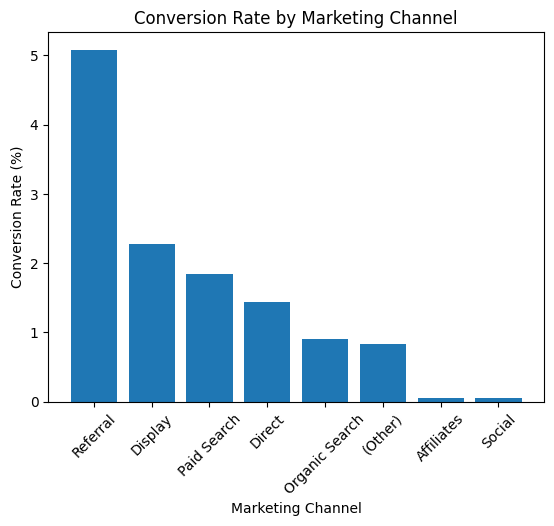

In [20]:
# Sort channels by conversion rate
df_plot = df_channel_kpis.sort_values('conversion_rate_pct', ascending=False)

plt.figure()
plt.bar(df_plot['channel_grouping'], df_plot['conversion_rate_pct'])
plt.xlabel('Marketing Channel')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Marketing Channel')
plt.xticks(rotation=45)
plt.show()


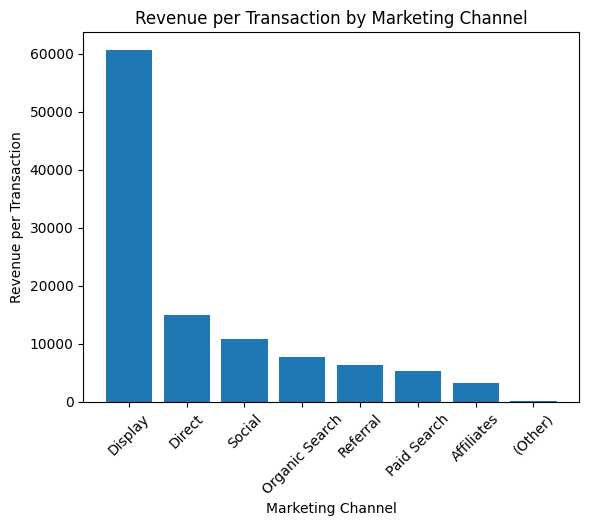

In [22]:
# Sort channels by revenue per transaction
df_plot_rev = df_channel_kpis.sort_values(
    'revenue_per_transaction',
    ascending=False
)

plt.figure()
plt.bar(df_plot_rev['channel_grouping'], df_plot_rev['revenue_per_transaction'])
plt.xlabel('Marketing Channel')
plt.ylabel('Revenue per Transaction')
plt.title('Revenue per Transaction by Marketing Channel')
plt.xticks(rotation=45)
plt.show()


## Insight

Channel-level analysis reveals clear performance trade-offs. Referral channels
deliver the highest conversion efficiency, while Display drives the highest
revenue per transaction, indicating high-value purchases despite lower volume.
In contrast, Social generates substantial traffic but underperforms across both
conversion and revenue metrics, making it a strong candidate for deprioritization.
